<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

## Company's Description 📇

AT&T Inc. is an American multinational telecommunications holding company headquartered at Whitacre Tower in Downtown Dallas, Texas. It is the world's largest telecommunications company by revenue and the third largest provider of mobile telephone services in the U.S. As of 2022, AT&T was ranked 13th on the Fortune 500 rankings of the largest United States corporations, with revenues of $168.8 billion! 😮

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms' content.

## Scope of this project 🖼️

To start off, AT&T would like you to use the folowing dataset:

[Dowload the Dataset](https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv)

## Helpers 🦮

To help you achieve this project, here are a few tips that should help you:

### Start simple
A good deep learing model does not necessarily have to be super complicated!

### Transfer learning
You do not have access to a whole lot of data, perhaps channeling the power of a more sophisticated model trained on billions of observations might help!

## Deliverable 📬

To complete this project, your team should:

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

In [124]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import io
import os
import re
import shutil
import string
import warnings

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization, LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [2]:
link = 'https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv'
data = pd.read_csv(link, encoding='ISO-8859-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
data['v1'].value_counts()

,count
v1,
ham,4825
spam,747


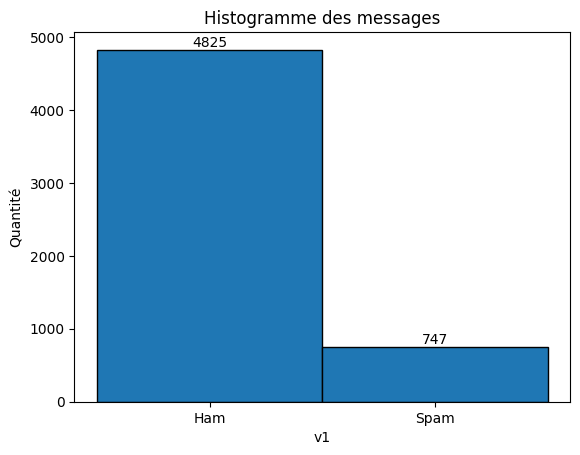

In [ ]:
# EDA
counts, bins, patches = plt.hist(data['v1'], bins=2, edgecolor='black')
plt.title('Histogramme des messages')
plt.xlabel('v1')
plt.ylabel('Quantité')
plt.xticks([0.25, 0.75], ['Ham', 'Spam'])
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, int(count),
             ha='center', va='bottom')
plt.show()

In [ ]:
data.describe(include='all')

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
data[data.iloc[:,4].isna() == False]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
2255,ham,I just lov this line: \Hurt me with the truth,I don't mind,i wil tolerat.bcs ur my someone..... But,"Never comfort me with a lie\"" gud ni8 and swe..."
3525,ham,\HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...,HAD A COOL NYTHO,TX 4 FONIN HON,"CALL 2MWEN IM BK FRMCLOUD 9! J X\"""""
4668,ham,"When I was born, GOD said, \Oh No! Another IDI...",GOD said,"\""OH No! COMPETITION\"". Who knew","one day these two will become FREINDS FOREVER!"""
5048,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""


## Preprocessing

In [39]:
sms_data = data.copy()

for i in [2, 3, 4]:
  sms_data.loc[sms_data.iloc[:,i].isna() == False,'v2'] += sms_data.loc[sms_data.iloc[:,i].isna() == False,'Unnamed: '+str(i)]

sms_data = sms_data[['v2', 'v1']].rename(columns = {'v2': 'message', 'v1': 'label'})
sms_data.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [40]:
# Compte du nombre de mots dans le SMS
sms_data['nb_mots'] = sms_data['message'].apply(lambda x: len(x.split(' ')))

In [41]:
sms_data.groupby('label')['nb_mots'].agg(['count', 'mean', 'median'])
sms_data.head()

,message,label,nb_mots
0,"Go until jurong point, crazy.. Available only ...",ham,20
1,Ok lar... Joking wif u oni...,ham,6
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,28
3,U dun say so early hor... U c already then say...,ham,11
4,"Nah I don't think he goes to usf, he lives aro...",ham,13


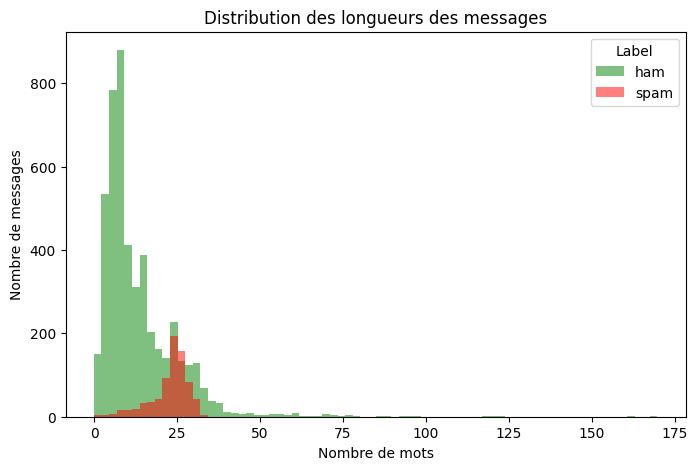

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

# Histogramme
labels = sms_data['label'].unique()
colors = ['green', 'red']
bins = np.linspace(sms_data['nb_mots'].min(), sms_data['nb_mots'].max(), 75)

for label, color in zip(labels, colors):
    subset = sms_data[sms_data['label'] == label]
    hist, edges = np.histogram(subset['nb_mots'], bins=bins)
    ax.bar(edges[:-1], hist, width=np.diff(edges), alpha=0.5, label=label, color=color)

# Personnalisation du graphique
ax.set_title('Distribution des longueurs des messages')
ax.set_xlabel('Nombre de mots')
ax.set_ylabel('Nombre de messages')
ax.legend(title='Label')

# Affichage
plt.show()

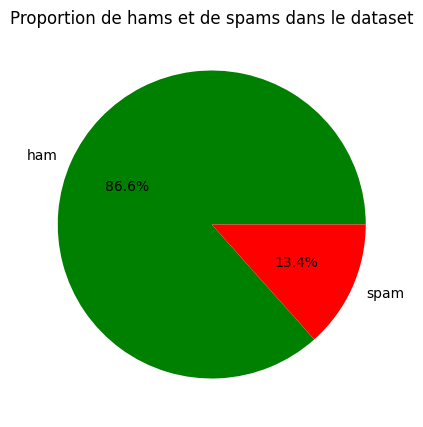

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

# Diagramme circulaire
label_counts = sms_data['label'].value_counts(normalize=True)
ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', colors=colors)
ax.set_title('Proportion de hams et de spams dans le dataset')

plt.show()

In [6]:
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
import en_core_web_md
nlp = en_core_web_md.load()
from spacy.lang.en.stop_words import STOP_WORDS

On émet l'hypothèse suivante qu'on va pouvoir distinguer les spams uniquement sur les mots "les plus importants" du message (s'il y a des termes qui sont "signatures" d'un spam, ou un champ lexical spécifique).

In [42]:
sms_data["message_clean"] = sms_data["message"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
sms_data["message_clean"] = sms_data["message_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
sms_data["message_clean"] = sms_data["message_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

sms_data.head()

,message,label,nb_mots,message_clean
0,"Go until jurong point, crazy.. Available only ...",ham,20,jurong point crazy available bugis n great wor...
1,Ok lar... Joking wif u oni...,ham,6,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,28,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,ham,11,u dun early hor u c
4,"Nah I don't think he goes to usf, he lives aro...",ham,13,nah think usf live


In [43]:
def is_spam(message):
  if(message=='spam'):
    return 1
  else:
    return 0

sms_data["label_encoded"] = sms_data.label.apply(is_spam)

sms_data.head()

,message,label,nb_mots,message_clean,label_encoded
0,"Go until jurong point, crazy.. Available only ...",ham,20,jurong point crazy available bugis n great wor...,0
1,Ok lar... Joking wif u oni...,ham,6,ok lar joke wif u oni,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,28,free entry 2 wkly comp win fa cup final tkts 2...,1
3,U dun say so early hor... U c already then say...,ham,11,u dun early hor u c,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,13,nah think usf live,0


In [44]:
# Récupérer 3 spams et 3 hams pour le test
test_indices = [5547, 5566, 5567, 5569, 5570, 5571]
sms_train = sms_data.drop(test_indices)
sms_test = sms_data.iloc[test_indices, :]
print('sms_train :')
display(sms_train)
print()
print('sms_test :')
display(sms_test)

sms_train :


,message,label,nb_mots,message_clean,label_encoded
0,"Go until jurong point, crazy.. Available only ...",ham,20,jurong point crazy available bugis n great wor...,0
1,Ok lar... Joking wif u oni...,ham,6,ok lar joke wif u oni,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,28,free entry 2 wkly comp win fa cup final tkts 2...,1
3,U dun say so early hor... U c already then say...,ham,11,u dun early hor u c,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,13,nah think usf live,0
...,...,...,...,...,...
5562,Ok lor... Sony ericsson salesman... I ask shuh...,ham,18,ok lor sony ericsson salesman ask shuhui gd 2 ...,0
5563,Ard 6 like dat lor.,ham,5,ard 6 like dat lor,0
5564,Why don't you wait 'til at least wednesday to ...,ham,15,wait ' til wednesday,0
5565,Huh y lei...,ham,3,huh y lei,0



sms_test :


,message,label,nb_mots,message_clean,label_encoded
5547,Had your contract mobile 11 Mnths? Latest Moto...,spam,28,contract mobile 11 mnth late motorola nokia et...,1
5566,REMINDER FROM O2: To get 2.50 pounds free call...,spam,28,reminder o2 250 pound free credit detail great...,1
5567,This is the 2nd time we have tried 2 contact u...,spam,30,2nd time try 2 contact u u win å750 pound priz...,1
5569,"Pity, * was in mood for that. So...any other s...",ham,10,pity mood soany suggestion,0
5570,The guy did some bitching but I acted like i'd...,ham,26,guy bitching act like interested buy week free,0
5571,Rofl. Its true to its name,ham,6,rofl true,0


In [45]:
xtrain, xval, ytrain, yval = train_test_split(sms_train['message_clean'], sms_train['label_encoded'], test_size=0.3)

In [81]:
# Définir le nombre maximal de mots à considérer et la longueur maximale des séquences
max_words = 5000
max_len = 150

# Initialiser le tokenizer avec le nombre maximal de mots
tokenizer = Tokenizer(num_words=max_words)

# Entraîner le tokenizer
tokenizer.fit_on_texts(xtrain)
tokenizer.fit_on_texts(xval)

# Convertir les textes en séquences de nombres entiers
train_seq = tokenizer.texts_to_sequences(xtrain)
val_seq = tokenizer.texts_to_sequences(xval)

# Remplir les séquences pour qu'elles aient toutes la même longueur
train_pad = pad_sequences(train_seq, maxlen=max_len)
val_pad = pad_sequences(val_seq, maxlen=max_len)

In [82]:
print(f"Shape of train_pad: {train_pad.shape}")
print(f"Shape of val_pad: {val_pad.shape}")

Shape of train_pad: (3896, 150)
Shape of val_pad: (1670, 150)


In [83]:
train = tf.data.Dataset.from_tensor_slices((train_pad, ytrain))
val = tf.data.Dataset.from_tensor_slices((val_pad, yval))

In [84]:
xtest = sms_test['message_clean']
ytest = sms_test['label_encoded']
test_seq = tokenizer.texts_to_sequences(xtest)
test_pad = pad_sequences(test_seq, maxlen=max_len)

test_pad

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 1373,
          30,  911, 2760,   67,  613,  106,  649,   10,  365,   83,   17,
         271, 1271,   17,   75, 2761, 

In [85]:
test = tf.data.Dataset.from_tensor_slices((test_pad, ytest))

In [86]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [87]:
for message, target in train_batch.take(1):
  print(message, target)

tf.Tensor(
[[   0    0    0 ...   46  821 2855]
 [   0    0    0 ...   15   50   50]
 [   0    0    0 ... 4949 1619 2798]
 ...
 [   0    0    0 ... 1787  131 3635]
 [   0    0    0 ... 2599 1622  193]
 [   0    0    0 ...  317   96    7]], shape=(64, 150), dtype=int32) tf.Tensor(
[0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0], shape=(64,), dtype=int64)


In [91]:
print(train_seq[:2])
print(train_pad[:2])

[[55, 3620, 3621, 208, 604, 3622, 938, 165, 219, 89, 281, 298, 3623, 372, 342, 3624, 939], [1072, 1, 8, 195, 77, 2364, 3625]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   55 3620 3621  208  604 3622  938
   165  219   89  281  298 3623  372  342 3624  939]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   

In [95]:
ytrain.value_counts()

,count
label_encoded,
0,3384
1,512


In [96]:
yval.value_counts()

,count
label_encoded,
0,1438
1,232


## Modèle simple


- On part d'un modèle simple
- On testera un modèle plus complexe par la suite


In [68]:
model_simple = Sequential([
    # Couche Dense classique
    Dense(8, activation='relu', input_shape=[150]),
    # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction sigmoid
    Dense(1, activation='sigmoid')
])

model_simple.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 8)                   │           1,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
opt1 = tf.keras.optimizers.Adam(name = 'Adam')
bce1 = tf.keras.losses.BinaryCrossentropy()
precision1 = tf.keras.metrics.Precision(name = 'precision')
recall1 = tf.keras.metrics.Recall(name = 'recall')
auc1 = tf.keras.metrics.AUC(name = 'auc')

In [70]:
model_simple.compile(optimizer=opt1,
                    loss=bce1,
                    metrics=['accuracy',
                             precision1,
                             recall1,
                             auc1])

In [71]:
history_simple = model_simple.fit(train_batch,
                                epochs=50,
                                validation_data=val_batch)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8013 - auc: 0.5431 - loss: 16.6163 - precision: 0.2586 - recall: 0.3101 - val_accuracy: 0.8353 - val_auc: 0.5822 - val_loss: 7.5423 - val_precision: 0.4018 - val_recall: 0.3793
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8361 - auc: 0.5789 - loss: 6.9270 - precision: 0.3854 - recall: 0.3498 - val_accuracy: 0.8563 - val_auc: 0.6336 - val_loss: 3.7260 - val_precision: 0.4787 - val_recall: 0.3879
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8775 - auc: 0.6854 - loss: 3.1599 - precision: 0.5121 - recall: 0.4362 - val_accuracy: 0.8677 - val_auc: 0.5787 - val_loss: 2.2910 - val_precision: 0.5714 - val_recall: 0.1897
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8758 - auc: 0.6534 - loss: 2.0229 - precision: 0.5716 - recall: 0.2643 - val_accuracy: 0.8629 - val_auc: 0.5478 - val_loss: 1.6227 - val_precision: 0.5333 - val_recall: 0.1034
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 

122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


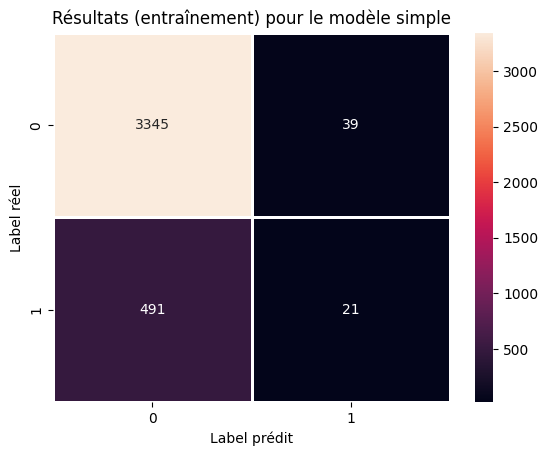

In [132]:
ypred_train = (model_simple.predict(train_pad) > 0.5).astype("int32")
ypred_val = (model_simple.predict(val_pad) > 0.5).astype("int32")

mtx = confusion_matrix(ytrain, ypred_train)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('Label réel')
plt.xlabel('Label prédit')
plt.title('Résultats (entraînement) pour le modèle simple')
plt.show()

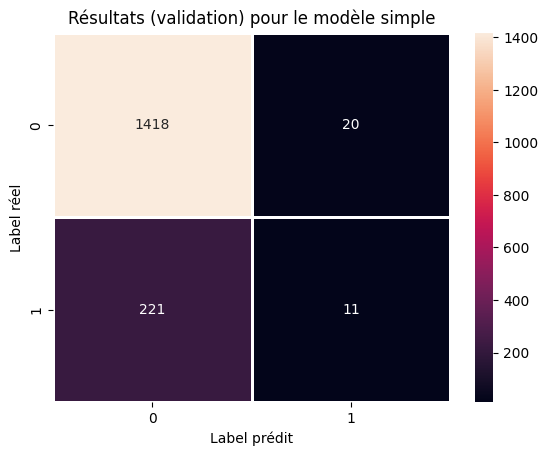

In [133]:
mtx = confusion_matrix(yval, ypred_val)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('Label réel')
plt.xlabel('Label prédit')
plt.title('Résultats (validation) pour le modèle simple')
plt.show()

## Modèle Embedded

In [102]:
# Définition des paramètres
vocab_size = tokenizer.num_words
embedding_dim = 64
max_len = 150

# model_embed = Sequential([
#     Embedding(vocab_size+1, 8, input_shape=[message.shape[1],], name="embedding"),
#     # Gobal average pooling
#     GlobalAveragePooling1D(),
#     # Couche Dense classique
#     Dense(16, activation='relu'),
#     # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction sigmoid
#     Dense(1, activation='sigmoid')
# ])

# Construction du modèle avec Embedding et LSTM
model_embed = tf.keras.Sequential([
    Embedding(vocab_size + 1, embedding_dim, input_shape=[max_len], name="embedding"),
    LSTM(units=64, return_sequences=True),  # LSTM avec 64 unités, retourne les séquences
    LSTM(units=32, return_sequences=False),  # LSTM avec 32 unités, retourne la dernière sortie
    Dense(16, activation='relu'),  # Couche dense avec 16 neurones et activation ReLU
    Dense(1, activation='sigmoid')  # Couche de prédiction binaire avec activation sigmoid
])

model_embed.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 150, 64)             │         320,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 150, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 366,049 (1.40 MB)

 Trainable params: 366,049 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

In [103]:
opt2 = tf.keras.optimizers.Adam(name = 'Adam_embed')
bce2 = tf.keras.losses.BinaryCrossentropy(from_logits=True)
precision2 = tf.keras.metrics.Precision(name = 'precision_embed')
recall2 = tf.keras.metrics.Recall(name = 'recall_embed')
auc2 = tf.keras.metrics.AUC(name = 'auc_embed')

In [104]:
model_embed.compile(optimizer=opt2,
                    loss=bce2,
                    metrics=['accuracy',
                             precision2,
                             recall2,
                             auc2])

In [105]:
history_embed = model_embed.fit(train_batch,
                                epochs=50,
                                validation_data=val_batch)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8177 - auc_embed: 0.6747 - loss: 0.4465 - precision_embed: 0.2870 - recall_embed: 0.1329 - val_accuracy: 0.9569 - val_auc_embed: 0.9336 - val_loss: 0.1923 - val_precision_embed: 0.9301 - val_recall_embed: 0.7457
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9773 - auc_embed: 0.9734 - loss: 0.1073 - precision_embed: 0.9725 - recall_embed: 0.8470 - val_accuracy: 0.9766 - val_auc_embed: 0.9780 - val_loss: 0.0879 - val_precision_embed: 0.9849 - val_recall_embed: 0.8448
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9926 - auc_embed: 0.9979 - loss: 0.0303 - precision_embed: 0.9889 - recall_embed: 0.9556 - val_accuracy: 0.9796 - val_auc_embed: 0.9789 - val_loss: 0.0783 - val_precision_embed: 0.9806 - val_recall_embed: 0.8707
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9970 - auc_embed: 0.9997 - loss: 0.0136 - precision_embed: 1.0000 - recall_embed: 0.9772 - val_accuracy:

122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


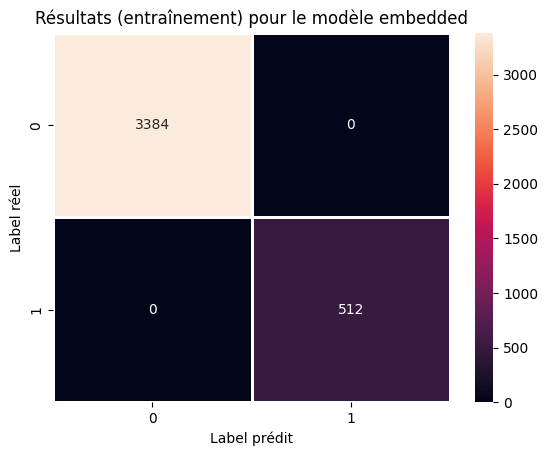

In [134]:
ypred_train = (model_embed.predict(train_pad) > 0.5).astype("int32")
ypred_val = (model_embed.predict(val_pad) > 0.5).astype("int32")

mtx = confusion_matrix(ytrain, ypred_train)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('Label réel')
plt.xlabel('Label prédit')
plt.title('Résultats (entraînement) pour le modèle embedded')
plt.show()

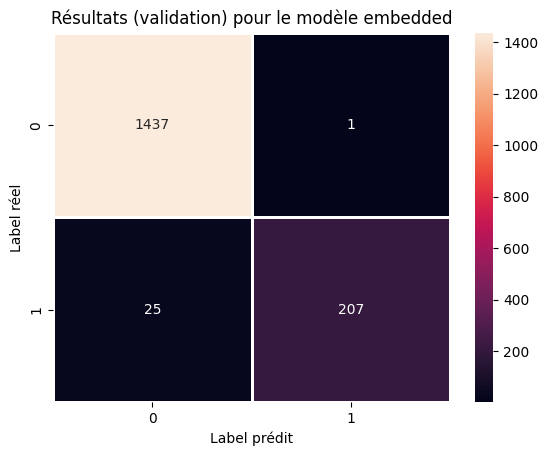

In [135]:
mtx = confusion_matrix(yval, ypred_val)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('Label réel')
plt.xlabel('Label prédit')
plt.title('Résultats (validation) pour le modèle embedded')
plt.show()

## Evaluation

### Modèle simple

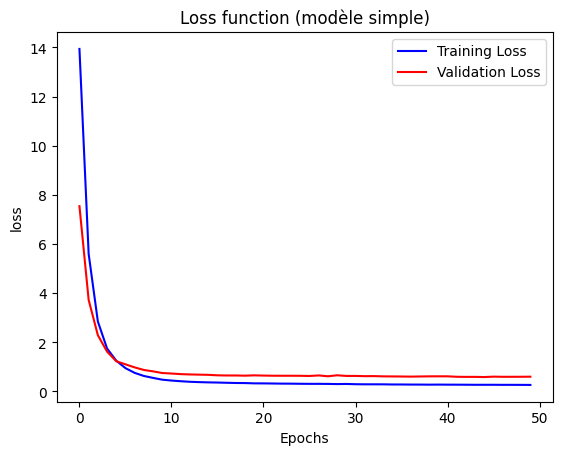

In [143]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history_simple.history["loss"], color="b", label="Training Loss")
plt.plot(history_simple.history["val_loss"], color="r", label="Validation Loss")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title('Loss function (modèle simple)')
plt.legend()
plt.show()

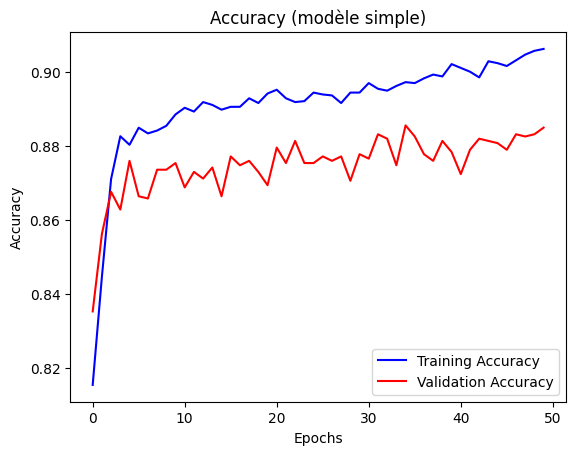

In [138]:
plt.plot(history_simple.history["accuracy"], color="b", label="Training Accuracy")
plt.plot(history_simple.history["val_accuracy"], color="r", label="Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title('Accuracy (modèle simple)')
plt.legend(loc='lower right')
plt.show()

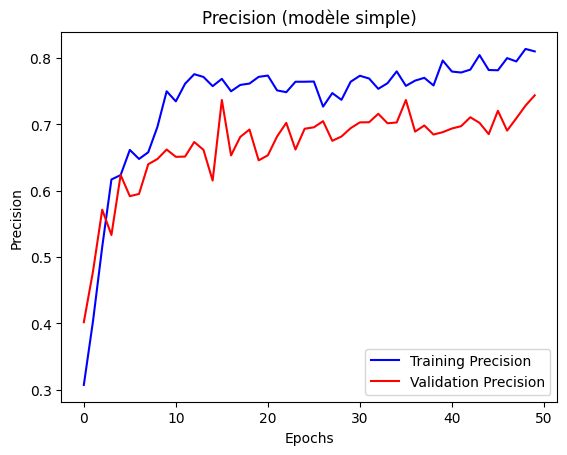

In [139]:
plt.plot(history_simple.history["precision"], color="b", label="Training Precision")
plt.plot(history_simple.history["val_precision"], color="r", label="Validation Precision")
plt.ylabel("Precision")
plt.xlabel("Epochs")
plt.title('Precision (modèle simple)')
plt.legend(loc='lower right')
plt.show()

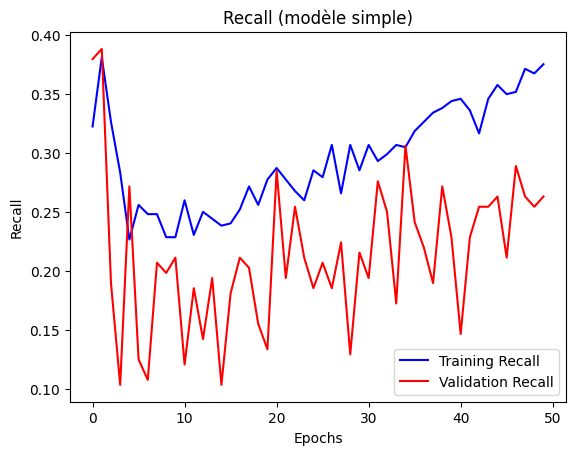

In [140]:
plt.plot(history_simple.history["recall"], color="b", label="Training Recall")
plt.plot(history_simple.history["val_recall"], color="r", label="Validation Recall")
plt.ylabel("Recall")
plt.xlabel("Epochs")
plt.title('Recall (modèle simple)')
plt.legend(loc='lower right')
plt.show()

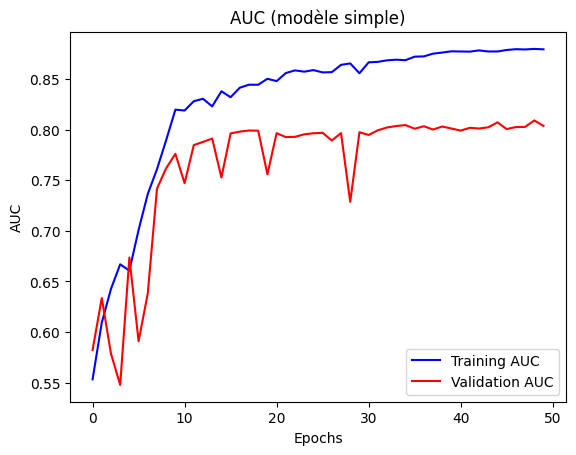

In [141]:
plt.plot(history_simple.history["auc"], color="b", label="Training AUC")
plt.plot(history_simple.history["val_auc"], color="r", label="Validation AUC")
plt.ylabel("AUC")
plt.xlabel("Epochs")
plt.title('AUC (modèle simple)')
plt.legend(loc='lower right')
plt.show()

### Modèle Embedding

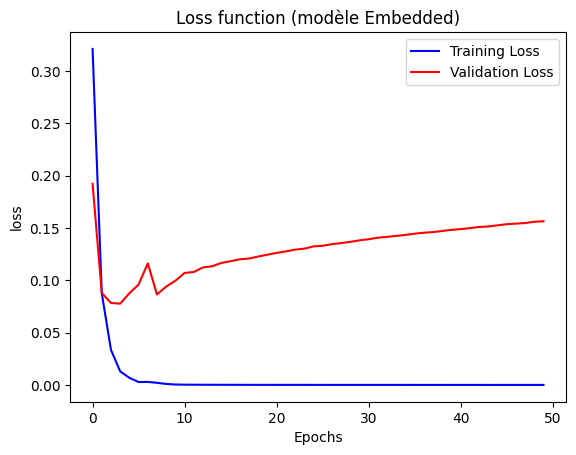

In [144]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history_embed.history["loss"], color="b", label="Training Loss")
plt.plot(history_embed.history["val_loss"], color="r", label="Validation Loss")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title('Loss function (modèle Embedded)')
plt.legend(loc='upper right')
plt.show()

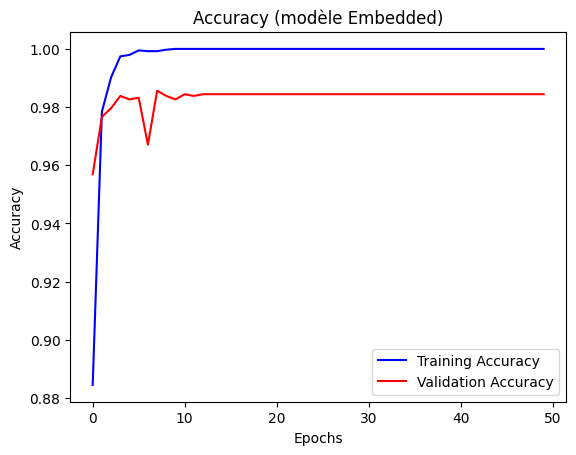

In [145]:
plt.plot(history_embed.history["accuracy"], color="b", label="Training Accuracy")
plt.plot(history_embed.history["val_accuracy"], color="r", label="Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title('Accuracy (modèle Embedded)')
plt.legend(loc='lower right')
plt.show()

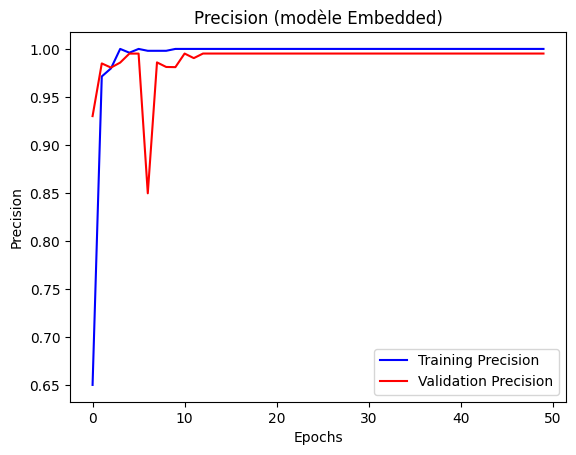

In [146]:
plt.plot(history_embed.history["precision_embed"], color="b", label="Training Precision")
plt.plot(history_embed.history["val_precision_embed"], color="r", label="Validation Precision")
plt.ylabel("Precision")
plt.xlabel("Epochs")
plt.title('Precision (modèle Embedded)')
plt.legend(loc='lower right')
plt.show()

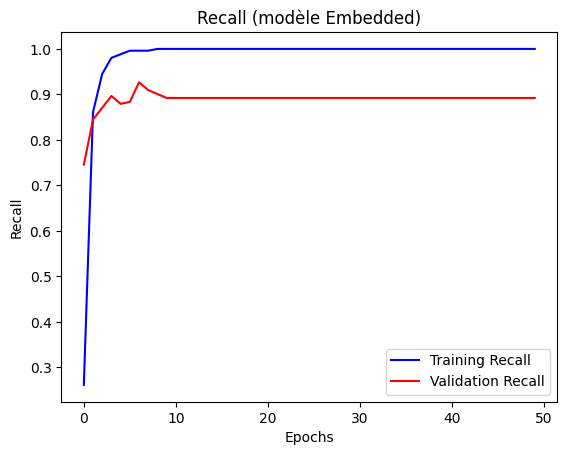

In [147]:
plt.plot(history_embed.history["recall_embed"], color="b", label="Training Recall")
plt.plot(history_embed.history["val_recall_embed"], color="r", label="Validation Recall")
plt.ylabel("Recall")
plt.xlabel("Epochs")
plt.title('Recall (modèle Embedded)')
plt.legend(loc='lower right')
plt.show()

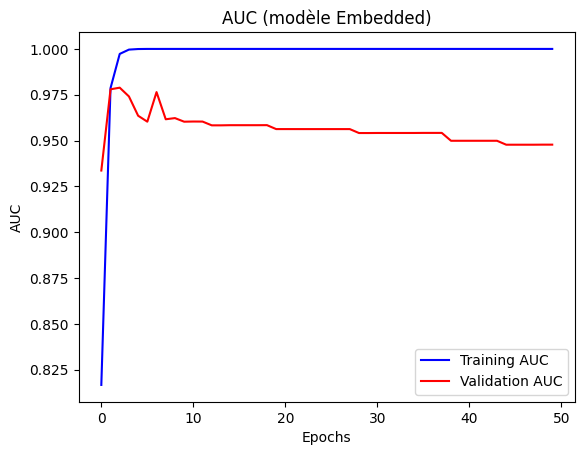

In [148]:
plt.plot(history_embed.history["auc_embed"], color="b", label="Training AUC")
plt.plot(history_embed.history["val_auc_embed"], color="r", label="Validation AUC")
plt.ylabel("AUC")
plt.xlabel("Epochs")
plt.title('AUC (modèle Embedded)')
plt.legend(loc='lower right')
plt.show()

## Prédictions

In [149]:
test_pad.shape

(6, 150)

In [150]:
train_pad.shape[1]

150

In [158]:
ytest

,label_encoded
5547,1
5566,1
5567,1
5569,0
5570,0
5571,0


In [179]:
new_text_padded = tf.keras.preprocessing.sequence.pad_sequences(test_pad, maxlen=train_pad.shape[1])

In [180]:
# Make a prediction
pred = model_simple.predict(new_text_padded)

print("Prédictions sur les messages tests pour le modèle simple")
for i in range(6):
  pred_value = float(pred[i])
  print(f"Prédiction {i+1} : {pred_value:2.6f} |", f"Vrai label {i+1} : {ytest.iloc[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prédictions sur les messages tests pour le modèle simple
Prédiction 1 : 0.000000 | Vrai label 1 : 1
Prédiction 2 : 0.000000 | Vrai label 2 : 1
Prédiction 3 : 0.000000 | Vrai label 3 : 1
Prédiction 4 : 0.000000 | Vrai label 4 : 0
Prédiction 5 : 0.000000 | Vrai label 5 : 0
Prédiction 6 : 0.000000 | Vrai label 6 : 0


In [181]:
# Make a prediction
pred = model_embed.predict(new_text_padded)

print("Prédictions sur les messages tests pour le modèle Embedded")
for i in range(6):
  pred_value = float(pred[i])
  print(f"Prédiction {i+1} : {pred_value:2.6f} |", f"Vrai label {i+1} : {ytest.iloc[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prédictions sur les messages tests pour le modèle Embedded
Prédiction 1 : 0.999995 | Vrai label 1 : 1
Prédiction 2 : 0.999984 | Vrai label 2 : 1
Prédiction 3 : 0.999996 | Vrai label 3 : 1
Prédiction 4 : 0.000008 | Vrai label 4 : 0
Prédiction 5 : 0.000015 | Vrai label 5 : 0
Prédiction 6 : 0.000008 | Vrai label 6 : 0


## Conclusion

On observe donc une bonne prédiction sur cet ensemble de test.

Pour rappel, on a enlevé la ponctuation et les stop words car on a fait l'hypothèse qu'on allait pouvoir distinguer les spams uniquement sur les mots "les plus importants" du message.

En examinant les messages de plus près (les tests par exemple), on constate qu'effectivement les messages faisant référence au temps (late, reminder, time) ont plus de chance d'être des spams.